In [1]:
!pip install kagglehub
!pip install path

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/modelnet10-princeton-3d-object-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/modelnet10-princeton-3d-object-dataset/versions/1


In [3]:
import torch
import numpy as np
import trimesh
from torch.utils.data import Dataset, DataLoader
from path import Path

def mesh_to_sparse_voxels(path, grid_size=32):
    """trimesh를 사용해 메쉬를 Voxel로 변환하고 정수 좌표를 반환합니다."""
    # 1. 메쉬 로드 및 정규화 (중심 이동 및 스케일링)
    mesh = trimesh.load(path)
    
    # 2. Voxelization (pitch는 한 칸의 크기)
    # 전체 크기(extents)를 grid_size로 나누어 해상도를 결정합니다.
    voxel_grid = mesh.voxelized(pitch=mesh.extents.max() / grid_size)
    
    # 3. 내부 채우기 (선택 사항: 속이 빈 메쉬라면 fill() 호출)
    # voxel_grid.fill() 
    
    # 4. 정수 좌표 추출 (N, 3)
    coords = voxel_grid.sparse_indices.astype(np.int32)
    
    return coords

class SparseModelNetDataset(Dataset):
    def __init__(self, root_dir, folder='train', grid_size=32):
        self.root_dir = Path(root_dir)
        self.grid_size = grid_size
        self.files = []
        
        # 카테고리 로드
        self.categories = sorted([d.name for d in self.root_dir.dirs()])
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        
        for cat in self.categories:
            new_dir = self.root_dir / cat / folder
            if new_dir.exists():
                for f in new_dir.files('*.off'):
                    self.files.append({'path': f, 'category': cat})

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_info = self.files[idx]
        
        # trimesh를 이용한 voxelize
        try:
            coords = mesh_to_sparse_voxels(file_info['path'], self.grid_size)
        except Exception as e:
            # 간혹 깨진 OFF 파일 대응: 단순 정점 로드 후 양자화 (fallback)
            mesh = trimesh.load(file_info['path'])
            pc = mesh.vertices
            pc_normalized = (pc - pc.min(0)) / (pc.max(0) - pc.min(0) + 1e-6)
            coords = np.unique((pc_normalized * (self.grid_size - 1)).astype(np.int32), axis=0)

        # 특징값 (간단히 1.0으로 초기화)
        feats = np.ones((coords.shape[0], 1), dtype=np.float32)
        label = self.label_map[file_info['category']]
        
        return torch.from_numpy(coords), torch.from_numpy(feats), label
def fast_mesh_to_coords(path, grid_size=32, num_samples=2048 * 4):
    """메쉬 표면에서 점을 샘플링하고 즉시 정수 좌표로 변환 (매우 빠름)"""
    mesh = trimesh.load(path)
    
    # 1. 메쉬 표면에서 고정된 개수의 점을 무작위 샘플링 (trimesh의 빠른 샘플링 이용)
    # 복셀화보다 훨씬 빠릅니다.
    points = mesh.sample(num_samples)
    
    # 2. 정규화 및 양자화
    p_min, p_max = points.min(0), points.max(0)
    points = (points - p_min) / (p_max - p_min + 1e-6)
    coords = (points * (grid_size - 1)).astype(np.int32)
    
    # 3. 중복 제거 (같은 복셀 칸에 들어간 점들 하나로 합침)
    return np.unique(coords, axis=0)

class FastSparseDataset(Dataset):
    def __init__(self, root_dir, folder='train', grid_size=32):
        self.root_dir = Path(root_dir)
        self.grid_size = grid_size
        self.files = []
        
        self.categories = sorted([d.name for d in self.root_dir.dirs()])
        self.label_map = {name: i for i, name in enumerate(self.categories)}
        
        for cat in self.categories:
            new_dir = self.root_dir / cat / folder
            if new_dir.exists():
                self.files.extend([{'path': f, 'label': self.label_map[cat]} for f in new_dir.files('*.off')])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_info = self.files[idx]
        # 샘플링 방식을 써서 훨씬 빠르게 로드
        coords = fast_mesh_to_coords(file_info['path'], self.grid_size)
        feats = np.ones((coords.shape[0], 1), dtype=np.float32)
        
        return torch.from_numpy(coords), torch.from_numpy(feats), file_info['label']
def sparse_collate_fn(batch):
    coords_list, feats_list, labels = zip(*batch)
    
    batch_coords = []
    for i, coords in enumerate(coords_list):
        # [batch_idx, x, y, z] 형태로 결합
        b_idx = torch.full((coords.shape[0], 1), i, dtype=torch.int32)
        batch_coords.append(torch.cat([b_idx, coords], dim=1))
    
    return {
        'coords': torch.cat(batch_coords, dim=0),
        'feats': torch.cat(feats_list, dim=0),
        'labels': torch.LongTensor(labels)
    }

# 실행 예시
# ds = SparseModelNetDataset(root_dir='./ModelNet10', grid_size=32)
# loader = DataLoader(ds, batch_size=8, shuffle=True, collate_fn=sparse_collate_fn)

In [ ]:
import sparsetriton
from sparsetriton.nn.modules.conv import Conv3d
from sparsetriton.nn.modules.linear import SparseLinear
from sparsetriton.nn.modules.spatial import SparsePooling
from sparsetriton.nn.modules.activation import ReLU
from torch import nn
import torch

from sparsetriton.tensor import SparseTensor

class ResConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, layer_n=3):
        super(ResConv3D, self).__init__()
        self.input_layer = Conv3d(in_channels, out_channels, kernel_size=3)

        self.layers = nn.ModuleList()
        for i in range(layer_n):
            self.layers.append(Conv3d(out_channels, out_channels, kernel_size=3))
            self.layers.append(ReLU())

    def forward(self, x:SparseTensor):
        x_in = self.input_layer(x)
        h = x_in
        for layer in self.layers:
            h = layer(h)    
        y = h.replace(h.F + x_in.F)
        return y


class SparseNet(nn.Module):
    def __init__(self, in_channels, num_classes, layer_n=3):
        super(SparseNet, self).__init__()
        
        self.layers = nn.ModuleList()
        current_channels = in_channels
        base_channels = 32

        for i in range(layer_n):
            # 층이 깊어질수록 채널을 2배씩 확장 (최대 256 등 제한 가능)
            out_channels = base_channels * (2 ** i)
            self.layers.append(ResConv3D(current_channels, out_channels))
            self.layers.append(Conv3d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, subm=False))
            
            current_channels = out_channels

        self.fc_net = nn.Sequential(
            nn.Linear(current_channels, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x: SparseTensor):

        for layer in self.layers:
            x = layer(x)
        x = x.dense().view(x.batch_size, -1)
        logits = self.fc_net(x)
        return logits

spnet = SparseNet(in_channels=1, num_classes=10, layer_n=6).cuda()

In [9]:
# 데이터 로드 (Path 설정 필수)
from sparsetriton.tensor import SparseTensor
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

ds = FastSparseDataset(root_dir=path + '/ModelNet10', grid_size=64)
loader = DataLoader(ds, batch_size=1, shuffle=True, collate_fn=sparse_collate_fn, num_workers=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = spnet.to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

# DataLoader 정의 (위에서 만든 ds와 collate_fn 사용)
# ds = FastSparseDataset(root_dir=path + '/ModelNet10', grid_size=64)
# loader = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=sparse_collate_fn)

print(f"🚀 Starting training on {device}...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 2. tqdm 진행 표시줄 설정
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch+1}/{epochs}")
    
    for i, batch in pbar:
        # 데이터 준비
        coords = batch['coords']
        feats = batch['feats']
        labels = batch['labels'].to(device)
        
        # SparseTensor 생성
        input_tensor = SparseTensor(feats, coords).to(device)
        # Forward pass
        # optimizer.zero_grad()
        outputs = model(input_tensor)
        
        loss = criterion(labels, outputs)
        
        # Backward & Optimize
        # loss.backward()
        
        # optimizer.step()
        
        # 통계 계산
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 3. tqdm 설명칸에 실시간 정보 업데이트
        current_acc = 100. * correct / total
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}", 
            'acc': f"{current_acc:.2f}%"
        })

    # 에폭 종료 후 요약 출력
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    print(f"✅ Epoch {epoch+1} Results -> Avg Loss: {epoch_loss:.4f}, Avg Acc: {epoch_acc:.2f}%")

# 4. 테스트 루프 (마지막에 한 번)
print("\n🔍 Running Final Test...")
test_ds = FastSparseDataset(root_dir=path + '/ModelNet10', folder='test', grid_size=64)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=sparse_collate_fn)

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_tensor = SparseTensor(batch['feats'], batch['coords'], batch_size=len(labels), spatial_shape=(64, 64, 64)).to(device)
        outputs = model(input_tensor)
        
        if outputs.dim() > 2:
            outputs = outputs.max(dim=1)[0].max(dim=1)[0].max(dim=1)[0]
            
        _, predicted = outputs.max(1)
        test_total += batch['labels'].size(0)
        test_correct += predicted.eq(batch['labels'].to(device)).sum().item()

print(f"\n🏆 Final Test Accuracy: {100. * test_correct / test_total:.2f}%")

🚀 Starting training on cuda...


Epoch 1/20:   0%|          | 0/3991 [00:03<?, ?it/s]


NotImplementedError: "host_softmax" not implemented for 'Long'

In [ ]:
outputs = model(input_tensor)

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        norm = param.grad.norm(2).item()
        print(f"Layer: {name:<30} | Grad Norm: {norm:.6f}")
print("="*50 + "\n")

# 최적화 단계
optimizer.step()
optimizer.zero_grad()

Layer: layers.0.input_layer.weight    | Grad Norm: 5239197184.000000
Layer: layers.0.input_layer.bias      | Grad Norm: 4475779072.000000
Layer: layers.0.layers.0.weight       | Grad Norm: 35915536.000000
Layer: layers.0.layers.0.bias         | Grad Norm: 22284506.000000
Layer: layers.0.layers.2.weight       | Grad Norm: 71610928.000000
Layer: layers.0.layers.2.bias         | Grad Norm: 308694784.000000
Layer: layers.0.layers.4.weight       | Grad Norm: 423707264.000000
Layer: layers.0.layers.4.bias         | Grad Norm: 3681230336.000000
Layer: layers.2.input_layer.weight    | Grad Norm: 36562161664.000000
Layer: layers.2.input_layer.bias      | Grad Norm: 98096592.000000
Layer: layers.2.layers.0.weight       | Grad Norm: 139000864.000000
Layer: layers.2.layers.0.bias         | Grad Norm: 771005.187500
Layer: layers.2.layers.2.weight       | Grad Norm: 210774336.000000
Layer: layers.2.layers.2.bias         | Grad Norm: 5771998.000000
Layer: layers.2.layers.4.weight       | Grad Norm: 3

In [ ]:
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

In [ ]:
print(f"✅ Epoch {epoch+1} Results -> Avg Loss: {epoch_loss:.4f}, Avg Acc: {epoch_acc:.2f}%")

NameError: name 'epoch_loss' is not defined

In [ ]:
import sparsetriton
from sparsetriton.nn.modules.conv import Conv3d
from sparsetriton.nn.modules.linear import SparseLinear
from sparsetriton.nn.modules.spatial import SparsePooling
from sparsetriton.nn.modules.activation import ReLU
from torch import nn
import torch

from sparsetriton.tensor import SparseTensor

class ResConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, layer_n=3):
        super(ResConv3D, self).__init__()
        self.input_layer = Conv3d(in_channels, out_channels, kernel_size=3)

        self.layers = nn.ModuleList()
        for i in range(layer_n):
            self.layers.append(Conv3d(out_channels, out_channels, kernel_size=3))
            self.layers.append(ReLU())

    def forward(self, x:SparseTensor):
        x_in = self.input_layer(x)
        h = x_in
        for layer in self.layers:
            h = layer(h)    
        y = h.replace(h.F + x_in.F)
        return y


class SparseNet(nn.Module):
    def __init__(self, in_channels, num_classes, layer_n=3):
        super(SparseNet, self).__init__()
        
        self.layers = nn.ModuleList()
        current_channels = in_channels
        base_channels = 32

        for i in range(layer_n):
            # 층이 깊어질수록 채널을 2배씩 확장 (최대 256 등 제한 가능)
            out_channels = base_channels * (2 ** i)
            self.layers.append(ResConv3D(current_channels, out_channels))
            self.layers.append(SparsePooling(kernel_size=3, mode="avg", stride=2, padding=1))
            
            current_channels = out_channels

        self.fc_net = nn.Sequential(
            nn.Linear(current_channels, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x: SparseTensor):

        print(x.F.abs().sum())
        for layer in self.layers:
            x = layer(x)
            print(x.F.abs().sum())
        
        x = x.dense().view(x.batch_size, -1)
        logits = self.fc_net(x)
        return logits

spnet = SparseNet(in_channels=1, num_classes=10, layer_n=6).cuda()

outputs = spnet(input_tensor)
outputs

tensor(102975., device='cuda:0')
tensor(681573.1250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(357257.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(222505.1562, device='cuda:0', grad_fn=<SumBackward0>)
tensor(51894.6758, device='cuda:0', grad_fn=<SumBackward0>)
tensor(50413.5781, device='cuda:0', grad_fn=<SumBackward0>)
tensor(9602.6982, device='cuda:0', grad_fn=<SumBackward0>)
tensor(11244.9258, device='cuda:0', grad_fn=<SumBackward0>)
tensor(1975.7053, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2696.9766, device='cuda:0', grad_fn=<SumBackward0>)
tensor(436.2053, device='cuda:0', grad_fn=<SumBackward0>)
tensor(603.1741, device='cuda:0', grad_fn=<SumBackward0>)
tensor(77.2256, device='cuda:0', grad_fn=<SumBackward0>)


tensor([[-0.0399,  0.1045,  0.0195, -0.0809,  0.1115,  0.0908,  0.0552, -0.1007,
          0.0863, -0.1058],
        [-0.0399,  0.1045,  0.0196, -0.0809,  0.1115,  0.0908,  0.0553, -0.1007,
          0.0862, -0.1058],
        [-0.0399,  0.1045,  0.0195, -0.0809,  0.1115,  0.0908,  0.0552, -0.1007,
          0.0862, -0.1057],
        [-0.0399,  0.1045,  0.0195, -0.0809,  0.1115,  0.0908,  0.0553, -0.1007,
          0.0862, -0.1058],
        [-0.0399,  0.1045,  0.0195, -0.0809,  0.1116,  0.0907,  0.0552, -0.1007,
          0.0863, -0.1058],
        [-0.0398,  0.1046,  0.0194, -0.0810,  0.1114,  0.0908,  0.0553, -0.1008,
          0.0863, -0.1057],
        [-0.0399,  0.1046,  0.0195, -0.0810,  0.1115,  0.0907,  0.0553, -0.1007,
          0.0862, -0.1058],
        [-0.0397,  0.1046,  0.0196, -0.0811,  0.1116,  0.0907,  0.0553, -0.1006,
          0.0862, -0.1058],
        [-0.0399,  0.1045,  0.0195, -0.0809,  0.1116,  0.0907,  0.0553, -0.1007,
          0.0863, -0.1058],
        [-0.0398,  

In [ ]:
outputs

tensor([[ 1.0153e+09, -2.8616e+09, -1.3107e+08,  2.5852e+09,  1.5827e+08,
         -1.2721e+09,  8.2918e+07,  4.3912e+08,  3.1001e+08, -1.9104e+09],
        [ 1.3487e+09, -2.5225e+09,  1.0237e+09,  2.0896e+09,  5.8662e+08,
         -1.4584e+09, -3.9265e+08,  2.9694e+09, -7.7608e+07, -3.5189e+09],
        [ 2.5249e+08, -1.4996e+09,  2.5118e+07,  1.2311e+09,  3.5929e+07,
          4.2436e+08,  8.0744e+08,  6.1061e+08, -1.1241e+06, -1.9410e+09],
        [ 1.2965e+09, -3.1824e+09,  1.4849e+08,  3.4715e+09,  9.8955e+07,
         -1.3382e+09,  6.3941e+08,  7.0518e+08,  5.5175e+08, -1.9867e+09],
        [ 2.1302e+08, -3.3945e+09,  7.7844e+08,  3.3307e+09, -7.7552e+08,
         -2.7841e+09, -8.8241e+07,  3.6556e+09, -9.9100e+08, -3.8614e+09],
        [ 2.0454e+09, -2.9835e+09,  1.6612e+09,  3.8249e+08,  1.1761e+09,
         -5.1297e+08, -1.1178e+08, -1.6802e+08, -1.3246e+09, -1.8530e+09],
        [ 1.2798e+09, -3.0829e+09,  1.0408e+09,  1.9589e+09, -7.1560e+07,
         -1.6427e+09, -3.4204e+0

In [ ]:
from torch.nn import AvgPool3d
import torch

x = torch.rand((1, 3, 15, 15, 15), device="cuda", dtype=torch.float32)
pool = AvgPool3d(1, 2, padding=0).cuda()
pool(x).shape

torch.Size([1, 3, 8, 8, 8])

In [ ]:
pool = SparsePooling(3, stride=2, padding=1, mode="avg").cuda()

In [ ]:
input_tensor.F.requires_grad = True

In [ ]:
pool(input_tensor).F.sum().backward()

In [ ]:
input_tensor.F.grad.max()

tensor(2., device='cuda:0')

In [ ]:
30 // 2

15

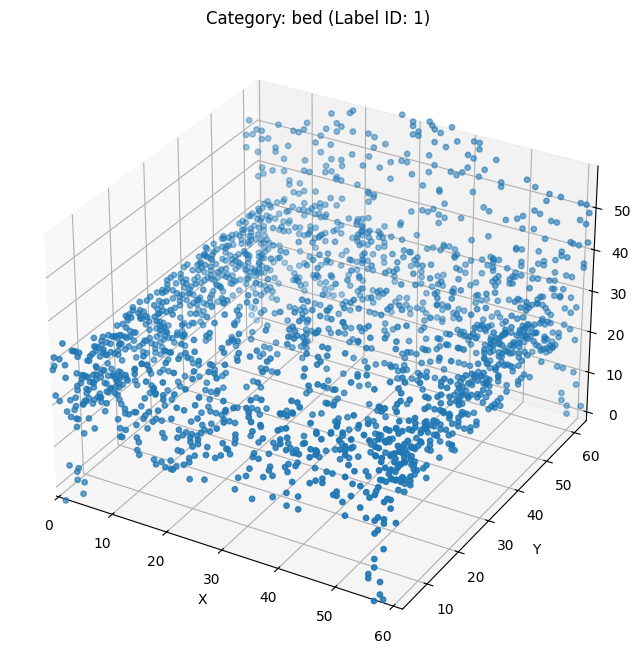

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch # torch가 임포트되어 있지 않을 수 있으므로 명시적으로 추가

# 시각화를 위해 루프를 다시 실행하고 첫 번째 배치에서 멈춥니다.
# ds와 loader 변수가 이전에 정의되었다고 가정합니다.
# 만약 ds 또는 loader가 정의되지 않았다면, 이전 셀들을 먼저 실행해야 합니다.
try:
    _ = loader # loader가 정의되었는지 확인
except NameError:
    print("Error: 'loader' is not defined. Please run the preceding cells first.")
    # 주의: 이 오류 메시지가 보이면, 데이터셋과 로더를 정의하는 이전 셀들을 먼저 실행해야 합니다.
    # 예를 들어, path 변수와 SparseModelNetDataset, DataLoader 정의 셀을 실행해야 합니다.


for batch in loader:
    coords = batch['coords']
    labels = batch['labels']

    # 첫 번째 아이템의 좌표만 선택 (batch_idx == 0)
    # item_coords는 텐서이며, .cpu().numpy()를 사용하여 matplotlib에 전달할 수 있습니다.
    item_coords = coords[coords[:, 0] == 0][:, 1:] # x, y, z 좌표
    item_label_id = labels[0].item()

    # 클래스 이름 찾기
    class_name = [name for name, idx in ds.label_map.items() if idx == item_label_id][0]

    # 3D 시각화
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    # matplotlib는 numpy 배열을 기대하므로 .cpu().numpy()를 사용합니다.
    ax.scatter(item_coords[:, 0].cpu().numpy(), item_coords[:, 1].cpu().numpy(), item_coords[:, 2].cpu().numpy(), s=15) # s는 점의 크기

    ax.set_title(f'Category: {class_name} (Label ID: {item_label_id})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 축의 스케일을 동일하게 맞추어 왜곡 방지
    # item_coords가 CUDA 텐서일 경우를 대비하여 .cpu() 호출 추가
    max_range = (item_coords.max(dim=0)[0] - item_coords.min(dim=0)[0]).max().item()
    mid = item_coords.float().mean(dim=0) # 평균 계산 시 float로 변환하여 정확성 유지
    ax.set_xlim(mid[0].item() - max_range / 2, mid[0].item() + max_range / 2)
    ax.set_ylim(mid[1].item() - max_range / 2, mid[1].item() + max_range / 2)
    ax.set_zlim(mid[2].item() - max_range / 2, mid[2].item() + max_range / 2)

    plt.show()

    break # 하나의 배치만 시각화하고 멈춤